# <font style = "color:rgb(50,120,229)">Image Classification using HOG + SVM</font>

In this module, we will learn the details of the Histogram of Oriented Gradients (HOG) feature descriptor. We will then use the HOG descriptor with Support Vector Machine (SVM) to build a classifier.

## <font style = "color:rgb(50,120,229)">HOG Descriptor in OpenCV</font>

OpenCV implements HOG using the HOGDescriptor class.

**Python** = hog : **cv2.HOGDescriptor**(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma, histogramNormType, L2HysThreshold, gammaCorrection, nlevels, useSignedGradients)

<center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-blockNormalization2.png"/></center>

&nbsp;
The image above will be used as a reference for describing important parameters below. Please see the description of HOG in the previous section if needed.

- **winSize** = This parameter is set to the size of the window over which the descriptor is calculated. In classification problems, we set it to the size of the image. E.g. we set it to 64x128 for pedestrian detection.

- **blockSize** = The size of the blue box in the image. The notion of blocks exist to tackle illumination variation. A large block size makes local changes less significant while a smaller block size weights local changes more. Typically blockSize is set to 2 x cellSize.

- **blockStride** = The blockStride determines the overlap between neighboring blocks and controls the degree of contrast normalization. Typically a blockStride is set to 50% of blockSize.

- **cellSize** = The cellSize is the size of the green squares. It is chosen based on the scale of the features important to do the classification. A very small cellSize would blow up the size of the feature vector and a very large one may not capture relevant information.

- **nbins** = Sets the number of bins in the histogram of gradients. The authors of the HOG paper had recommended a value of 9 to capture gradients between 0 and 180 degrees in 20 degrees increments. 

- **derivAperture** = Size of the Sobel kernel used for derivative calculation.

- **winSigma** = According to the HOG paper, it is useful to “downweight pixels near the edges of the block by applying a Gaussian spatial window to each pixel before accumulating orientation votes into cells”. winSigma is the standard deviation of this Gaussian. In practice, it is best to leave this parameter to default ( -1 ). On doing so, winSigma is automatically calculated as shown below: winSigma = ( blockSize.width + blockSize.height ) / 8

- **histogramNormType** = In the HOG paper, the authors use four different kinds of normalization. OpenCV 3.2 implements only one of those types L2Hys. So, we simply use the default. L2Hys is simply L2 normalization followed by a threshold (L2HysThreshold)where all values above a threshold are clipped to that value.

- **L2HysThreshold** = Threshold used in L2Hys normalization. E.g. If the L2 norm of a vector is  [0.87, 0.43, 0.22], the L2Hys normalization with L2HysThreshold = 0.8 is [0.8, 0.43, 0.22].

- **gammaCorrection** = Boolean indicating whether or not Gamma correction should be done as a pre-processing step.

- **nlevels** = Number of pyramid levels used during detection. It has no effect when the HOG descriptor is used for classification.

- **signedGradient** = Typically gradients can have any orientation between 0 and 360 degrees. These gradients are referred to as “signed” gradients as opposed to “unsigned” gradients that drop the sign and take values between 0 and 180 degrees. In the original HOG paper, unsigned gradients were used for pedestrian detection.

## <font style = "color:rgb(50,120,229)">Training a HOG based Classifier for Eye Glasses</font>
In this section, we share the code and walk you through the steps of building a HOG based classifier. The classifier looks at an image patch around the eyes and classifies it as wearing glasses or not wearing glasses.

In [1]:
import cv2
import numpy as np
from cropEyeRegion import getCroppedEyeRegion
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
import os
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0,10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
predictions2Label = {0: "No Glasses", 1: "With Glasses"}

## <font style="color:rgb(50,120,229)">Data preparation</font>

The below function reads the images in a specified directory. It creates two lists for storing train and test images. Also creates lists for train and test labels. The number of testing images is kept at 20% of the total number of images.

In [4]:
# Path1 is class 0 and Path2 is class 1
path1 = DATA_PATH + 'images/glassesDataset/cropped_withoutGlasses2'
path2 = DATA_PATH + 'images/glassesDataset/cropped_withGlasses2'

In [5]:
def getTrainTest(path, class_val, test_fraction = 0.2):
  testData = []
  trainData = []
  trainLabels = []
  testLabels = []
  inputDir = os.path.expanduser(path)

  # Get images from the directory and find number of train 
  # and test samples
  if os.path.isdir(inputDir):
    images = os.listdir(inputDir)
    images.sort()
    nTest = int(len(images) * test_fraction)

  for counter, img in enumerate(images):

    im = cv2.imread(os.path.join(inputDir, img))
    # Add nTest samples to testing data
    if counter < nTest:              
      testData.append(im)
      testLabels.append(class_val)
    else:   
      # Add nTrain samples to training data
      trainData.append(im)
      trainLabels.append(class_val)

  return trainData, trainLabels, testData, testLabels

<table>
    <tr>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-sample5.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-sample1.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-sample3.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-sample6.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-sample4.jpg"/></center></th>
        <th><center><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w7-m2-sample2.jpg"/></center></th>
    </tr>
    <tr>
        <td colspan="3"><center>Sample Images from the dataset with glasses</center>
</td>
        <td colspan=4""><center>Sample Images from the dataset without glasses</center>
</td>
    </tr>
</table>

## <font style="color:rgb(50,120,229)">Setting up the SVM Classifier</font>

The SVM classifier is initialized using the function. We set the parameters like

- Type of Kernel
- Gamma
- C

In [6]:
def svmInit(C, gamma):
  model = cv2.ml.SVM_create()
  model.setGamma(gamma)
  model.setC(C)
  model.setKernel(cv2.ml.SVM_RBF)
  model.setType(cv2.ml.SVM_C_SVC)

  return model

The SVM classifier is trained using the function. The data for training needs to be given in the specific format as given below. We also save the model to a yml file.

In [7]:
def svmTrain(model, samples, responses):
  model.train(samples, cv2.ml.ROW_SAMPLE, responses)
  return model

This function is used to get the classifier output or prediction.

In [8]:
def svmPredict(model, samples):
  return model.predict(samples)[1].ravel()

This function finds the predictions for all the test images in the dataset and finds the accuracy.

In [9]:
def svmEvaluate(model, samples, labels):
  predictions = svmPredict(model, samples)
  accuracy = (labels == predictions).mean()
  print('Percentage Accuracy: %.2f %%' % (accuracy * 100))
  return accuracy

The below function converts the hog descriptors from array to Mat type. This is required for giving it to the SVM training

In [10]:
def prepareData(data):
  featureVectorLength = len(data[0])
  features = np.float32(data).reshape(-1, featureVectorLength)
  return features

## <font style="color:rgb(50,120,229)">Setup the HOG Feature Descriptor</font>

The below function computes the hog descriptors for a given array of images. We should specify the images in a list.

In [11]:
def computeHOG(hog, data):

  hogData = []
  for image in data:
    hogFeatures = hog.compute(image)
    hogData.append(hogFeatures)

  return hogData

The dataset for training is kept at the specified location. The images are loaded using the functions described above

Here, we specify the parameters of the HOG descriptor.



In [12]:
# Initialize hog parameters
winSize = (96, 32)
blockSize = (8, 8)
blockStride = (8, 8)
cellSize = (4, 4)
nbins = 9
derivAperture = 0
winSigma = 4.0
histogramNormType = 1
L2HysThreshold = 2.0000000000000001e-01
gammaCorrection = 1
nlevels = 64

hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, 
                      nbins,derivAperture, winSigma, 
                      histogramNormType,L2HysThreshold, 
                      gammaCorrection, nlevels, 1)

## <font style="color:rgb(50,120,229)">Load Data into Train and Test variables</font>

In [13]:
# Get training and testing images for both classes
negTrainImages, negTrainLabels, negTestImages, negTestLabels = \
getTrainTest(path1, 0, .2)
posTrainImages, posTrainLabels, posTestImages, posTestLabels = \
getTrainTest(path2, 1, .2)

# Append Positive and Negative Images for Train and Test
trainImages = np.concatenate((np.array(negTrainImages), 
                        np.array(posTrainImages)), 
                            axis=0)
testImages = np.concatenate((np.array(negTestImages), 
                          np.array(posTestImages)), 
                          axis=0)

# Append Positive and Negative Labels for Train and Test
trainLabels = np.concatenate((np.array(negTrainLabels), 
                          np.array(posTrainLabels)), 
                          axis=0)
testLabels = np.concatenate((np.array(negTestLabels), 
                          np.array(posTestLabels)), 
                          axis=0)

## <font style="color:rgb(50,120,229)">Compute Features</font>

Here, we compute the HOG descriptors for training and test data. Next, we convert the data to a format required for SVM classifier



In [14]:
### Feature computation for the training and testing data  ##
trainHOG = computeHOG(hog, trainImages)
testHOG = computeHOG(hog, testImages)

# Convert hog data into features recognized by SVM model
trainFeatures = prepareData(trainHOG)
testFeatures = prepareData(testHOG)

## <font style="color:rgb(50,120,229)">Train the SVM Model </font>

Here, we specify the parameters for SVM Classifier and train the model using the training features obtained above.

In [15]:
###########  SVM Training  ##############
model = svmInit(C=2.5, gamma=0.02)  # C = 0.1, gamma 10 for 
#linear kernel
model = svmTrain(model, trainFeatures, trainLabels)
model.save("../results/eyeGlassClassifierModel.yml")

Testing and finding the accuracy on the test data

## <font style="color:rgb(50,120,229)">Evaluate the model and Check the Accuracy</font>

In [16]:
##########  SVM Testing  ###############
# We will load the model again and test the model
# This is just to explain how to load an SVM model
# You can use the model directly
savedModel = cv2.ml.SVM_load("../results/eyeGlassClassifierModel.yml")

# Find accuracy of the test data by evaluating the model on 
# the test data
accuracy = svmEvaluate(savedModel, testFeatures, testLabels)

Percentage Accuracy: 92.45 %


## <font style="color:rgb(50,120,229)">Check the result visually</font>

Here, we use the trained model to perform classification / prediction of a new image. The functions above require the images to be in a vector. First, we crop the eye region from the image using the dlib landmark points. Next, we convert the cropped image to an array and then compute the HOG descriptors. Next, we load the saved model and use the predict function to get the predictions.

In [17]:
# Perform for a separate test image
filename = DATA_PATH + "images/glassesDataset/glasses_4.jpg"
testImage = cv2.imread(filename)
cropped = getCroppedEyeRegion(testImage)
testHOG = computeHOG(hog, np.array([cropped]))
testFeatures = prepareData(testHOG)
predictions = svmPredict(savedModel, testFeatures)
print("Prediction = {}"
      .format(predictions2Label[int(predictions[0])]))

Eye Height between : 49,148
Prediction = With Glasses


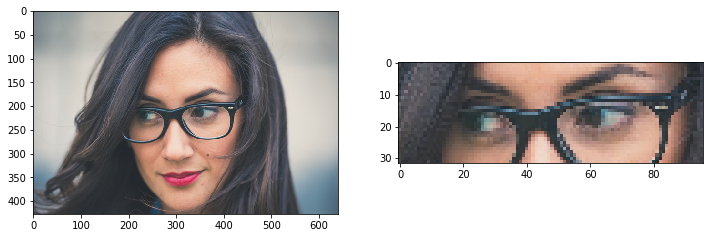

In [18]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(testImage[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(cropped[:,:,::-1])
plt.show()

In [19]:
# Perform for a separate test image
filename = DATA_PATH + "images/glassesDataset/no_glasses1.jpg"
testImage = cv2.imread(filename)
cropped = getCroppedEyeRegion(testImage)
testHOG = computeHOG(hog, np.array([cropped]))
testFeatures = prepareData(testHOG)
predictions = svmPredict(savedModel, testFeatures)
print("Prediction = {}"
      .format(predictions2Label[int(predictions[0])]))

Eye Height between : 26,79
Prediction = No Glasses


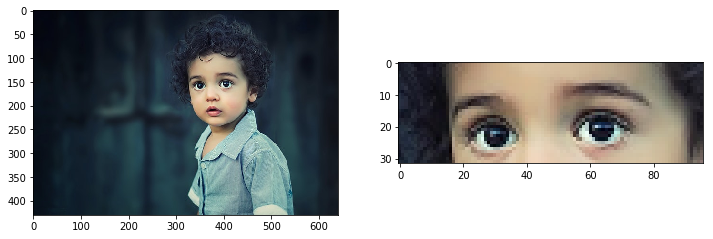

In [20]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(testImage[:,:,::-1])
plt.subplot(1,2,2)
plt.imshow(cropped[:,:,::-1])
plt.show()

#### <font style = "color:rgb(200,0,0)">We have provided a separate script along with the code which runs the classifier on the webcam input. Do try it out!</font>

# <font style = "color:rgb(50,120,229)">References and Further Reading</font>
- https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf
- http://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial
- http://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html
- https://en.wikipedia.org/wiki/Support_vector_machine